# Import library

In [1]:
!pip install tensorflowjs
!pip install tensorflow==2.15.0
!pip3 install tensorflow_decision_forests==1.8.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 106.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tabulate
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

In [3]:
print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.15.0


# hyperparameter

In [4]:
LEARNING_RATE = 0.00001
NUM_OUTPUTS = 16
NUM_EPOCHS = 100
VAL_SET_SIZE = 0.2
BATCH_SIZE = 4

# Load dataset

In [5]:
df_tourism = pd.read_csv('tourism.csv')
df_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [6]:
df_user = pd.read_csv('user.csv')
df_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [7]:
df_user_rating = pd.read_csv('tourism_rating.csv')
df_user_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


# Processing dataset

In [8]:
df_tourism = df_tourism.drop(['Coordinate','Time_Minutes','Unnamed: 11', 'Unnamed: 12'], axis=1)

In [9]:
df_tourism.columns = df_tourism.columns.str.lower()

In [10]:
df_user.columns = df_user.columns.str.lower()

In [11]:
df_user_rating.columns = df_user_rating.columns.str.lower()

In [12]:
def classify_age(age):
  if 0 <= age <= 10:
    return 1
  elif 11 <= age <= 20:
    return 2
  elif 21 <= age <= 30:
    return 3
  elif 31 <= age <= 40:
    return 4
  elif 41 <= age <= 50:
    return 5
  elif age >= 51:
    return 6
  else:
    return 0

In [13]:
df_user['classify_age'] = df_user['age'].apply(classify_age)

In [14]:
df_user['classify_age'].unique()

array([2, 3, 4])

In [15]:
def extract_city(location):
  return location.split(',')[0]

In [16]:
df_user['city'] = df_user['location'].apply(extract_city)

In [17]:
df_user_rating = df_user_rating.sample(n=df_tourism.shape[0], random_state=42)

In [18]:
df_user_rating = pd.merge(df_user_rating, df_user[['user_id', 'classify_age', 'city']], on='user_id', how='left')

In [19]:
df_user_rating

,user_id,place_id,place_ratings,classify_age,city
0,188,207,3,4,Kota Gede
1,142,268,2,3,Bekasi
2,54,103,3,4,Serang
3,144,119,3,2,Depok
4,138,288,5,3,Yogyakarta
...,...,...,...,...,...
432,13,296,2,2,Depok
433,124,158,3,3,Bogor
434,246,379,1,3,Jakarta Pusat
435,141,366,5,4,Kota Gede


In [20]:
def normalize_jakarta(city):
  if city in ['Jakarta Timur', 'Jakarta Pusat', 'Jakarta Selatan', 'Jakarta Barat', 'Jakarta Utara']:
    return 'Jakarta'
  else:
    return city

df_user_rating['city'] = df_user_rating['city'].apply(normalize_jakarta)

In [21]:
df_user_rating['city'].unique()

array(['Kota Gede', 'Bekasi', 'Serang', 'Depok', 'Yogyakarta', 'Karawang',
       'Cirebon', 'Bogor', 'Jakarta', 'Sragen', 'Solo', 'Palembang',
       'Nganjuk', 'Semarang', 'Subang', 'Ponorogo', 'Surabaya', 'Lampung',
       'Tanggerang', 'Bandung', 'Madura', 'Purwakarat', 'Cilacap',
       'Klaten'], dtype=object)

In [22]:
city = np.hstack((df_user_rating['city'].unique(), df_tourism['city'].unique()))

In [23]:
city_unique = np.unique(city)

In [24]:
city_unique

array(['Bandung', 'Bekasi', 'Bogor', 'Cilacap', 'Cirebon', 'Depok',
       'Jakarta', 'Karawang', 'Klaten', 'Kota Gede', 'Lampung', 'Madura',
       'Nganjuk', 'Palembang', 'Ponorogo', 'Purwakarat', 'Semarang',
       'Serang', 'Solo', 'Sragen', 'Subang', 'Surabaya', 'Tanggerang',
       'Yogyakarta'], dtype=object)

In [25]:
from sklearn.preprocessing import LabelEncoder

city_label_encoder = LabelEncoder()
city_label_encoder.fit(city_unique)

df_user_rating['city_encoded'] = city_label_encoder.transform(df_user_rating['city'])
df_tourism['city_encoded'] = city_label_encoder.transform(df_tourism['city'])


In [26]:
city_mapping = dict(zip(city_label_encoder.classes_, city_label_encoder.transform(city_label_encoder.classes_)))

In [27]:
city_mapping

{'Bandung': 0,
 'Bekasi': 1,
 'Bogor': 2,
 'Cilacap': 3,
 'Cirebon': 4,
 'Depok': 5,
 'Jakarta': 6,
 'Karawang': 7,
 'Klaten': 8,
 'Kota Gede': 9,
 'Lampung': 10,
 'Madura': 11,
 'Nganjuk': 12,
 'Palembang': 13,
 'Ponorogo': 14,
 'Purwakarat': 15,
 'Semarang': 16,
 'Serang': 17,
 'Solo': 18,
 'Sragen': 19,
 'Subang': 20,
 'Surabaya': 21,
 'Tanggerang': 22,
 'Yogyakarta': 23}

In [28]:
df_user_rating

,user_id,place_id,place_ratings,classify_age,city,city_encoded
0,188,207,3,4,Kota Gede,9
1,142,268,2,3,Bekasi,1
2,54,103,3,4,Serang,17
3,144,119,3,2,Depok,5
4,138,288,5,3,Yogyakarta,23
...,...,...,...,...,...,...
432,13,296,2,2,Depok,5
433,124,158,3,3,Bogor,2
434,246,379,1,3,Jakarta,6
435,141,366,5,4,Kota Gede,9


In [29]:
df_tourism

,place_id,place_name,description,category,city,price,rating,lat,long,city_encoded
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153,6
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125,6
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,-6.125312,106.833538,6
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,-6.302446,106.895156,6
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,-6.124190,106.839134,6
...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,-7.433859,112.719906,21
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,-7.291347,112.739822,21
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,-7.275296,112.754938,21
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,-7.294330,112.761753,21


# user feature

In [30]:
data = []
for _, row in df_user_rating.iterrows():
    # Cari informasi tempat berdasarkan place_id
    place = df_tourism[df_tourism['place_id'] == row['place_id']].iloc[0]  # Ambil baris pertama yang cocok
    data.append({
        "user_id": row["user_id"],
        "place_name": place["place_name"],
        "category": place["category"],
        "rating": row["place_ratings"],
        "age": row["classify_age"],
        "city": row["city_encoded"]
    })
print(data)

[{'user_id': 188, 'place_name': 'Heha Sky View', 'category': 'Taman Hiburan', 'rating': 3, 'age': 4, 'city': 9}, {'user_id': 142, 'place_name': 'Sudut Pandang Bandung', 'category': 'Taman Hiburan', 'rating': 2, 'age': 3, 'city': 1}, {'user_id': 54, 'place_name': 'Tugu Pal Putih Jogja', 'category': 'Taman Hiburan', 'rating': 3, 'age': 4, 'city': 17}, {'user_id': 144, 'place_name': 'Lava Bantal', 'category': 'Budaya', 'rating': 3, 'age': 2, 'city': 5}, {'user_id': 138, 'place_name': 'Masjid Salman ITB', 'category': 'Tempat Ibadah', 'rating': 5, 'age': 3, 'city': 23}, {'user_id': 191, 'place_name': 'Taman Barunawati', 'category': 'Taman Hiburan', 'rating': 2, 'age': 4, 'city': 7}, {'user_id': 19, 'place_name': 'Pelabuhan Marina', 'category': 'Bahari', 'rating': 3, 'age': 3, 'city': 4}, {'user_id': 158, 'place_name': 'Gua Maria Kerep Ambarawa', 'category': 'Cagar Alam', 'rating': 2, 'age': 3, 'city': 2}, {'user_id': 191, 'place_name': 'Masjid Nasional Al-Akbar', 'category': 'Tempat Ibadah'

In [31]:
df_user_place_rating = pd.DataFrame(data)
df_user_place_rating.head()

,user_id,place_name,category,rating,age,city
0,188,Heha Sky View,Taman Hiburan,3,4,9
1,142,Sudut Pandang Bandung,Taman Hiburan,2,3,1
2,54,Tugu Pal Putih Jogja,Taman Hiburan,3,4,17
3,144,Lava Bantal,Budaya,3,2,5
4,138,Masjid Salman ITB,Tempat Ibadah,5,3,23


In [32]:
average_ratings = (
    df_user_place_rating.groupby(["user_id", "category"])["rating"]
    .mean()
    .unstack(fill_value=0)
    .reset_index()
)

In [33]:
df_user_place_rating = df_user_place_rating.merge(average_ratings, on="user_id", suffixes=("", "_avg"))

In [34]:
category_encoded = pd.get_dummies(df_user_place_rating["category"], prefix="", prefix_sep="")
category_encoded.columns = category_encoded.columns.str.lower()

In [35]:
df_user_place_rating = pd.concat([df_user_place_rating, category_encoded], axis=1)

In [36]:
columns_to_keep = ["user_id"] + list(average_ratings.columns[1:]) + list(category_encoded.columns)
result = df_user_place_rating[columns_to_keep]

In [37]:
result = result.drop(result.columns[-6:], axis=1)

In [38]:
result

,user_id,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,188,0.0,4.0,0.000000,0.0,2.0,0.0
1,142,0.0,0.0,0.000000,0.0,2.0,0.0
2,54,0.0,0.0,0.000000,0.0,2.0,0.0
3,144,2.5,3.0,0.000000,0.0,3.0,0.0
4,138,2.0,0.0,0.000000,0.0,0.0,5.0
...,...,...,...,...,...,...,...
432,13,0.0,2.0,0.000000,0.0,2.0,0.0
433,124,3.0,2.0,0.000000,0.0,0.0,0.0
434,246,1.0,0.0,2.666667,0.0,0.0,0.0
435,141,2.0,0.0,0.000000,0.0,5.0,4.0


In [39]:
df_user_rating

,user_id,place_id,place_ratings,classify_age,city,city_encoded
0,188,207,3,4,Kota Gede,9
1,142,268,2,3,Bekasi,1
2,54,103,3,4,Serang,17
3,144,119,3,2,Depok,5
4,138,288,5,3,Yogyakarta,23
...,...,...,...,...,...,...
432,13,296,2,2,Depok,5
433,124,158,3,3,Bogor,2
434,246,379,1,3,Jakarta,6
435,141,366,5,4,Kota Gede,9


In [40]:
# merged_df = pd.merge(df_user_place_rating, df_user_rating[['user_id', 'classify_age', 'city_encoded']], on='user_id', how='left')
# result['classify_age'] = merged_df['classify_age']
# result['city'] = merged_df['city']

In [41]:
result

,user_id,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,188,0.0,4.0,0.000000,0.0,2.0,0.0
1,142,0.0,0.0,0.000000,0.0,2.0,0.0
2,54,0.0,0.0,0.000000,0.0,2.0,0.0
3,144,2.5,3.0,0.000000,0.0,3.0,0.0
4,138,2.0,0.0,0.000000,0.0,0.0,5.0
...,...,...,...,...,...,...,...
432,13,0.0,2.0,0.000000,0.0,2.0,0.0
433,124,3.0,2.0,0.000000,0.0,0.0,0.0
434,246,1.0,0.0,2.666667,0.0,0.0,0.0
435,141,2.0,0.0,0.000000,0.0,5.0,4.0


In [42]:
user = result.drop(columns=["user_id"])

In [43]:
user_features = result.columns

In [44]:
user_features

Index(['user_id', 'Bahari', 'Budaya', 'Cagar Alam', 'Pusat Perbelanjaan',
       'Taman Hiburan', 'Tempat Ibadah'],
      dtype='object')

In [45]:
result

,user_id,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,188,0.0,4.0,0.000000,0.0,2.0,0.0
1,142,0.0,0.0,0.000000,0.0,2.0,0.0
2,54,0.0,0.0,0.000000,0.0,2.0,0.0
3,144,2.5,3.0,0.000000,0.0,3.0,0.0
4,138,2.0,0.0,0.000000,0.0,0.0,5.0
...,...,...,...,...,...,...,...
432,13,0.0,2.0,0.000000,0.0,2.0,0.0
433,124,3.0,2.0,0.000000,0.0,0.0,0.0
434,246,1.0,0.0,2.666667,0.0,0.0,0.0
435,141,2.0,0.0,0.000000,0.0,5.0,4.0


# item feature

In [46]:
category_encoded = pd.get_dummies(df_tourism["category"], prefix="")
category_encoded.columns = category_encoded.columns.str.lower()
category_encoded = category_encoded.astype(int)
tourism_one_hot = pd.concat([df_tourism["place_id"], category_encoded], axis=1)
# tourism_one_hot = pd.concat([tourism_one_hot, df_tourism['city_encoded']], axis=1)
# tourism_one_hot = pd.concat([tourism_one_hot, df_tourism['price']], axis=1)

In [47]:
tourism_one_hot.rename(columns={
    "_bahari": "Bahari",
    "_budaya": "Budaya",
    "_cagar alam": "Cagar Alam",
    "_pusat perbelanjaan": "Pusat Perbelanjaan",
    "_taman hiburan": "Taman Hiburan",
    "_tempat ibadah": "Tempat Ibadah"
}, inplace=True)

In [48]:
tourism_one_hot.head()

,place_id,Bahari,Budaya,Cagar Alam,Pusat Perbelanjaan,Taman Hiburan,Tempat Ibadah
0,1,0,1,0,0,0,0
1,2,0,1,0,0,0,0
2,3,0,0,0,0,1,0
3,4,0,0,0,0,1,0
4,5,0,0,0,0,1,0


In [49]:
item_features = tourism_one_hot.columns

In [50]:
item = tourism_one_hot.drop(columns=["place_id"])

In [51]:
user.shape

(437, 6)

In [52]:
item.shape

(437, 6)

# scaled data

In [53]:
unscaled_item = item.copy()
unscaled_user = user.copy()
unscaled_y = df_tourism['rating'].copy()

In [54]:
scalerItem = StandardScaler()
scalerUser = StandardScaler()
scalerTarget = StandardScaler()

In [55]:
scaled_item = scalerItem.fit_transform(item)
scaled_user = scalerUser.fit_transform(user)
scaled_y = scalerTarget.fit_transform(df_tourism['rating'].values.reshape(-1, 1))

In [56]:
print(np.allclose(unscaled_item, scalerItem.inverse_transform(scaled_item)))
print(np.allclose(unscaled_user, scalerUser.inverse_transform(scaled_user)))

True
True


# pemisahan data

In [57]:
item_train, item_test, user_train, user_test, y_train, y_test = train_test_split(
    scaled_item,
    scaled_user,
    scaled_y,
    test_size=VAL_SET_SIZE,
    random_state=42
)

In [58]:
tourism_dict = df_tourism.set_index("place_id")["place_name"].to_dict()

In [59]:
def get_user_to_genre(user_rating, tourism):
    merged = user_rating.merge(tourism, on="place_id")
    user_to_genre = merged.groupby("user_id")["category"].apply(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    return user_to_genre

user_to_genre = get_user_to_genre(df_user_rating, df_tourism)

# Model

In [60]:
import tensorflow as tf

def create_embedding_model(num_features):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      # tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=16, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(units=1)
  ])
  return model

num_user_features = user_train.shape[1]
num_item_features = item_train.shape[1]

user_embedding_model = create_embedding_model(num_user_features)
item_embedding_model = create_embedding_model(num_item_features)

input_user = tf.keras.layers.Input(shape=(num_user_features,))
input_item = tf.keras.layers.Input(shape=(num_item_features,))

vector_user = user_embedding_model(input_user)
vector_item = item_embedding_model(input_item)

dot_user_item = tf.keras.layers.Dot(axes=1)([vector_user, vector_item])

model = tf.keras.Model(inputs=[input_user, input_item], outputs=dot_user_item)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1)                    11777     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    11777     ['input_2[0][0]']             
                                                                                              

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [62]:
history = model.fit([user_train, item_train], y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=([user_test, item_test], y_test))

Epoch 1/100
88/88 [==============================] - 5s 22ms/step - loss: 0.7594 - mae: 0.7594 - val_loss: 0.7569 - val_mae: 0.7569
Epoch 2/100
88/88 [==============================] - 1s 10ms/step - loss: 0.7591 - mae: 0.7591 - val_loss: 0.7570 - val_mae: 0.7570
Epoch 3/100
88/88 [==============================] - 1s 9ms/step - loss: 0.7588 - mae: 0.7588 - val_loss: 0.7570 - val_mae: 0.7570
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.7589 - mae: 0.7589 - val_loss: 0.7571 - val_mae: 0.7571
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 0.7590 - mae: 0.7590 - val_loss: 0.7571 - val_mae: 0.7571
Epoch 6/100
88/88 [==============================] - 1s 7ms/step - loss: 0.7589 - mae: 0.7589 - val_loss: 0.7572 - val_mae: 0.7572
Epoch 7/100
88/88 [==============================] - 0s 5ms/step - loss: 0.7585 - mae: 0.7585 - val_loss: 0.7571 - val_mae: 0.7571
Epoch 8/100
88/88 [==============================] - 1s 7ms/step - loss: 0.7583 -

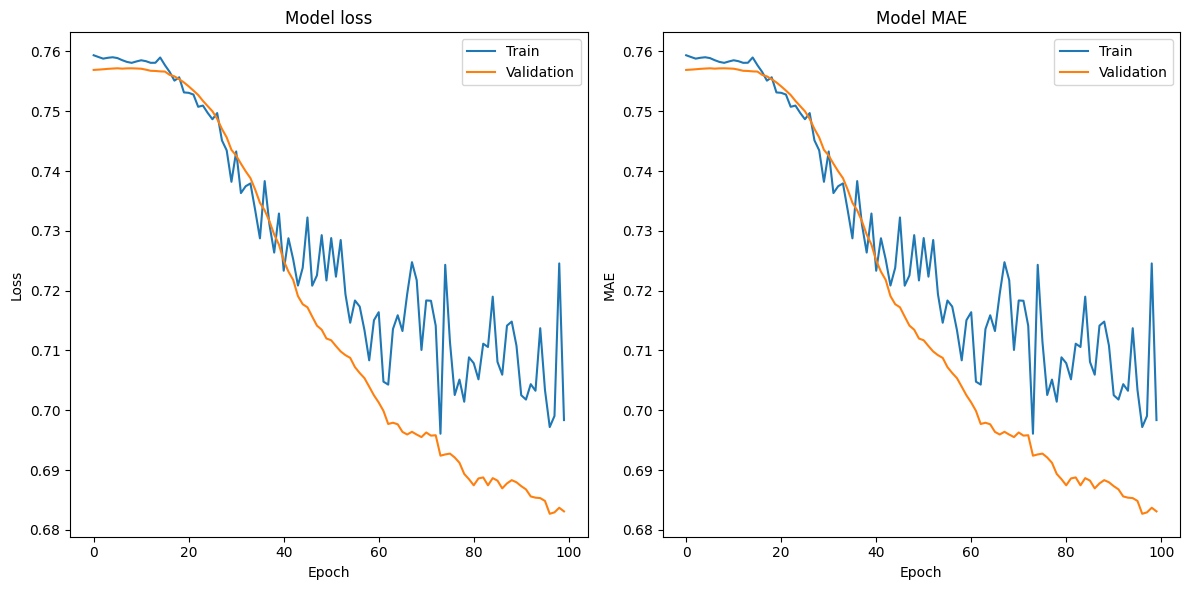

In [63]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Prediction

In [64]:
user_features

Index(['user_id', 'Bahari', 'Budaya', 'Cagar Alam', 'Pusat Perbelanjaan',
       'Taman Hiburan', 'Tempat Ibadah'],
      dtype='object')

In [65]:
item_features

Index(['place_id', 'Bahari', 'Budaya', 'Cagar Alam', 'Pusat Perbelanjaan',
       'Taman Hiburan', 'Tempat Ibadah'],
      dtype='object')

In [66]:
user_vec = np.array([[0, 0, 5, 2, 0, 0]])

In [67]:
def gen_user_vecs(user_vec, num_items):
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs

In [68]:
user_vecs = gen_user_vecs(user_vec,len(item))

suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item)

y_p = model.predict([suser_vecs, sitem_vecs])

y_pu = scalerTarget.inverse_transform(y_p)

 1/14 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


14/14 [==============================] - 0s 2ms/step


In [69]:
suser_vecs

array([[-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743],
       [-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743],
       [-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743],
       ...,
       [-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743],
       [-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743],
       [-0.56664958, -0.81759082,  2.18821255,  1.59687549, -1.04871055,
        -0.22417743]])

In [70]:
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()

In [71]:
sorted_ypu = y_pu[sorted_index]

In [72]:
# menggunakan formula haversine
import math
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    radius = 6371
    distance = radius * c
    return distance

In [73]:
def get_pred_places_df(y_pu, tourism_dict, tourism_one_hot, df_tourism, given_lat, given_lon, radius=10):
    table_data = []
    for i in range(len(y_pu)):
        original_index = sorted_index[i]
        place_id = tourism_one_hot.iloc[original_index]['place_id']
        place_name = tourism_dict.get(place_id, "Unknown Place")
        rating = y_pu[i][0]
        place_info = df_tourism[df_tourism['place_id'] == place_id].iloc[0]
        lat = place_info['lat']
        lon = place_info['long']
        distance = calculate_distance(given_lat, given_lon, lat, lon)
        if distance <= radius:
            table_data.append([place_id, place_name, rating, distance])
    df_pred_places = pd.DataFrame(table_data, columns=["Place ID", "Place Name", "Predicted Rating", "Distance (km)"])
    df_pred_places['Predicted Rating'] = df_pred_places['Predicted Rating'].map("{:.2f}".format)
    df_pred_places['Distance (km)'] = df_pred_places['Distance (km)'].map("{:.2f}".format)

    return df_pred_places

In [74]:
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()
sorted_ypu   = y_pu[sorted_index]
predict_data = get_pred_places_df(y_pu, tourism_dict, tourism_one_hot, df_tourism, -7.799438469931893, 110.36847049152439, radius=10)

In [75]:
predict_data.head(20)

,Place ID,Place Name,Predicted Rating,Distance (km)
0,125,Alun-alun Utara Keraton Yogyakarta,4.53,0.67
1,113,Gedung Agung Yogyakarta,4.48,0.53
2,107,Bangsal Pagelaran,4.48,0.80
3,105,Candi Donotirto,4.41,0.91
4,102,Monumen Batik Yogyakarta,4.53,0.46
5,101,Kampung Wisata Sosro Menduran,4.41,1.07
6,115,Monumen Sanapati,4.48,1.30
7,118,Museum Sonobudoyo Unit I,4.41,0.60
8,124,Kauman Pakualaman Yogyakarta,4.53,0.76
9,150,Wisata Kraton Jogja,4.53,0.97


# Simpan model ke format javascript

In [76]:
# import time
# saved_model_path = "./{}.h5".format(int(time.time()))

# model.save(saved_model_path)

# print(f"Model disimpan di: {saved_model_path}")
model.save("sample_data/tf_keras.h5")

tfjs.converters.save_keras_model(model, "sample_data/result")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
!tensorflowjs_converter --input_format=keras sample_data/tf_keras.h5 sample_data/tfjs_model_tf

2024-12-12 05:27:25.929418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 05:27:25.929479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 05:27:25.931186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 05:27:27.166020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [78]:
# !tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model 1732806971.h5 tfjs_model

In [79]:
try:
    model = load_model('sample_data/tf_keras.h5')
    print("Model berhasil dimuat dengan arsitektur lengkap.")
except Exception as e:
    print("Gagal memuat model:", e)
    print("Kemungkinan file hanya berisi weights.")


Model berhasil dimuat dengan arsitektur lengkap.


In [80]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2024-12-12 05:27:31.299799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 05:27:31.299868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 05:27:31.301535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 05:27:32.527949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    

In [81]:
import json

scaler_item_mean = scalerItem.mean_.tolist()
scaler_item_scale = scalerItem.scale_.tolist()

scaler_user_mean = scalerUser.mean_.tolist()
scaler_user_scale = scalerUser.scale_.tolist()

scaler_target_mean = scalerTarget.mean_.tolist()
scaler_target_scale = scalerTarget.scale_.tolist()

scalers = {
    'scaler_item_mean': scaler_item_mean,
    'scaler_item_scale': scaler_item_scale,
    'scaler_user_mean': scaler_user_mean,
    'scaler_user_scale': scaler_user_scale,
    'scaler_target_mean': scaler_target_mean,
    'scaler_target_scale': scaler_target_scale
}

with open('scalers.json', 'w') as f:
    json.dump(scalers, f)

scaled_data = {
    'scaled_item': scaled_item.tolist(),
    'scaled_user': scaled_user.tolist(),
    'scaled_y': scaled_y.tolist()
}

with open('scaled_data.json', 'w') as f:
    json.dump(scaled_data, f)


In [82]:
# // Fungsi untuk memuat file JSON
# async function loadJSON(url) {
#     const response = await fetch(url);
#     return await response.json();
# }

# async function main() {
#     // Memuat file JSON
#     const scalers = await loadJSON('scalers.json');
#     const scaledData = await loadJSON('scaled_data.json');

#     // Mendapatkan nilai mean dan scale untuk item, user, dan target
#     const scalerItemMean = scalers.scaler_item_mean;
#     const scalerItemScale = scalers.scaler_item_scale;
#     const scalerUserMean = scalers.scaler_user_mean;
#     const scalerUserScale = scalers.scaler_user_scale;
#     const scalerTargetMean = scalers.scaler_target_mean;
#     const scalerTargetScale = scalers.scaler_target_scale;

#     // Menstandarkan data input yang akan digunakan untuk prediksi (misalnya, user dan item)
#     const unscaledItem = [/* data item asli untuk prediksi */];
#     const unscaledUser = [/* data user asli untuk prediksi */];

#     // Menstandarkan data input sesuai dengan scaler yang sudah dimuat
#     const standardizedItem = standardize(unscaledItem, scalerItemMean, scalerItemScale);
#     const standardizedUser = standardize(unscaledUser, scalerUserMean, scalerUserScale);

#     // Melakukan prediksi dengan TensorFlow.js
#     await predict(standardizedUser, standardizedItem);
# }

# // Fungsi untuk menstandarkan data dengan mean dan scale
# function standardize(data, mean, scale) {
#     return data.map((value, index) => (value - mean[index]) / scale[index]);
# }

# // Fungsi untuk memuat dan menggunakan model TensorFlow.js untuk prediksi
# async function predict(userVec, itemVec) {
#     const model = await loadModel();  // Fungsi untuk memuat model TensorFlow.js
#     const userTensor = tf.tensor([userVec]);
#     const itemTensor = tf.tensor([itemVec]);

#     const prediction = model.predict([userTensor, itemTensor]);
#     prediction.print();
# }

# // Panggil fungsi utama
# main();


In [83]:
# // Menstandarkan rating jika diperlukan
# const unscaledRating = [/* rating asli untuk prediksi */];
# const standardizedRating = standardize(unscaledRating, scalerTargetMean, scalerTargetScale);


In [84]:
item.to_csv("item.csv", index=False)